# Resource-Constrained Project Scheduling (RCPSP)

This example schedules project activities with precedence relations and
a single renewable resource capacity.


## Problem Description

Schedule project activities with precedence relations and a single
renewable resource capacity. Each activity has a fixed duration and
resource demand.

Objective: minimize the makespan.


## Mathematical Model

Definitions:
$$
I_a: \text{interval of activity } a
$$
$$
p_a: \text{duration}, \quad d_a: \text{demand}, \quad C: \text{capacity}
$$

Constraints:
$$
end_a \le start_b \quad \forall (a,b) \in P
$$
$$
\sum_{a \in A} d_a \cdot active_a(t) \le C \quad \forall t
$$

Objective:
$$
\min \max_{a \in A} end_a
$$


## Imports


In [1]:
# Imports
from pycsp3 import *
from pycsp3_scheduling import *  

## Problem Data


In [2]:
# Activity data: (duration, resource_usage)
activities = {
    'A': (5, 2),
    'B': (3, 1),
    'C': (4, 2),
    'D': (6, 1),
}

precedences = [
    ('A', 'B'),
    ('A', 'C'),
    ('B', 'D'),
    ('C', 'D'),
]

resource_capacity = 3
activity_order = list(activities)
horizon = sum(d for d, _ in activities.values())


## Build the Model


In [3]:
clear()
from pycsp3_scheduling.variables.interval import clear_interval_registry

clear_interval_registry()

tasks = {}
for name, (duration, _) in activities.items():
    tasks[name] = IntervalVar(
        start=(0, horizon),
        end=(0, horizon),
        size=duration,
        name=name
    )


In [4]:
# Precedence constraints
satisfy(end_before_start(tasks[before], tasks[after]) for before, after in precedences)

# Cumulative resource usage
resource_usage = None
for name, (_, usage) in activities.items():
    p = pulse(tasks[name], usage)
    resource_usage = p if resource_usage is None else resource_usage + p

satisfy(cumul_range(resource_usage, 0, resource_capacity))


cumulative(origins:[iv_s_0, iv_s_1, iv_s_2, iv_s_3], lengths:[5, 3, 4, 6], heights:[2, 1, 2, 1], condition:(le,3))

In [5]:
objective_expr = Maximum(end_time(tasks[name]) for name in activity_order)
minimize(objective_expr)


## Solve


In [6]:
result = solve()

if result in (SAT, OPTIMUM):
    print("Solution found." + (" (Optimal)" if result == OPTIMUM else ""))
    for name in activity_order:
        val = interval_value(tasks[name])
        print(f"{name}: [{val.start}, {val.end})")
    makespan = max(interval_value(tasks[name]).end for name in activity_order)
    print(f"Makespan: {makespan}")
else:
    print("No solution found.")


Solution found. (Optimal)
A: [0, 5)
B: [5, 8)
C: [5, 9)
D: [9, 15)
Makespan: 15


## Stats


In [7]:
print("Model statistics:", model_statistics())
if result in (SAT, OPTIMUM):
    objective_value = globals().get("makespan")
    print("Solution statistics:", solution_statistics(status=result, objective=objective_value))


Model statistics: ModelStatistics(nb_interval_vars=4, nb_optional_interval_vars=0, nb_sequences=0, nb_sequences_with_types=0, nb_cumul_functions=0, nb_state_functions=0)
Solution statistics: SolutionStatistics(status=OPTIMUM, objective_value=15, solve_time=None, nb_interval_vars=4, nb_intervals_present=4, nb_intervals_absent=0, min_start=0, max_end=15, makespan=15, span=15)


## Visualization


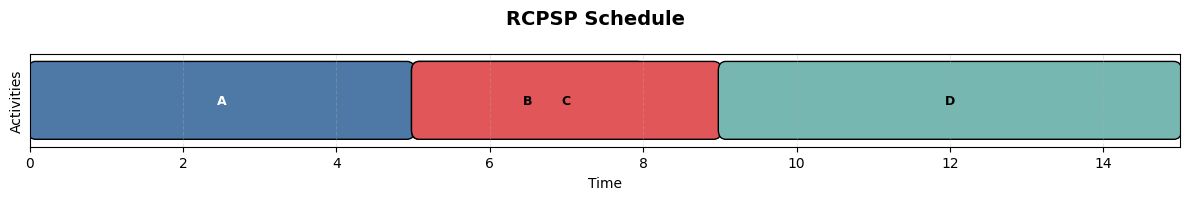

In [8]:
if result in (SAT, OPTIMUM):
    visu.reset()
    makespan = max(interval_value(tasks[name]).end for name in activity_order)
    visu.timeline("RCPSP Schedule", origin=0, horizon=makespan)
    visu.panel("Activities")

    schedule = []
    for name in activity_order:
        val = interval_value(tasks[name])
        schedule.append((val.start, val.end, name))
    schedule.sort()

    for idx, (start, end, name) in enumerate(schedule):
        visu.interval(start, end, name, color=idx)

    if visu.is_visu_enabled():
        visu.show()
    else:
        print("Visualization disabled (matplotlib not available).")
